# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

Video N°155: Importing a script full of helper functions (and saving lots of space)

## Creating helper functions

In previous notebooks, we 've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

We've done this for some of the functions we've used previously here:

```python
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
```
> 🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_function.py`, so you'll have to redownload it if you want access to your helper functions.

In [45]:
import os
import random
import zipfile

# Import helper functions we're going to use in this notebook
from MachineLearningUtils.training_utilities.model_callbacks import create_tensorboard_callback
from MachineLearningUtils.data_visualization.model_learning_curves import plot_loss_curves
from MachineLearningUtils.data_visualization.image_visualization import walk_through_dir, display_random_images_from_class
from MachineLearningUtils.data_acquisition.data_downloader import download_data, extract_archive_file

Video N°156: Downloading and turning our images into a TensorFlow BatchDataset

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [2]:
# Get 10% of training data of 10 classes of Food101
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
download_data(url=url,file_path="10_food_classes_10_percent.zip", extract=True)

The file 10_food_classes_10_percent.zip already exists.
Extracting 10_food_classes_10_percent.zip as ZIP...
10_food_classes_10_percent.zip has been extracted to current directory.


In [3]:
# Check out how many images and subdirectories are in dataset
walk_through_dir(dir_path="10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

In [4]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [5]:
# Args for image_dataset_from_directory
idfd_args={
    "image_size":(224, 224),
    "label_mode":"categorical",
    "batch_size":32
}

In [6]:
import tensorflow as tf
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            **idfd_args)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                **idfd_args)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


2024-03-31 14:17:17.522073: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-03-31 14:17:17.522097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: wm18vw2023
2024-03-31 14:17:17.522102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: wm18vw2023
2024-03-31 14:17:17.522187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 545.23.8
2024-03-31 14:17:17.522201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 545.23.8
2024-03-31 14:17:17.522206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 545.23.8
2024-03-31 14:17:17.522400: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network

In [7]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[2.17704086e+01 1.72295914e+01 1.10000000e+01]
   [2.33112240e+01 1.64030609e+01 1.04030609e+01]
   [2.52908173e+01 1.36479588e+01 9.86224461e+00]
   ...
   [1.13000000e+02 1.39000000e+02 1.39846954e+02]
   [1.11000000e+02 1.39000000e+02 1.40142883e+02]
   [1.11000000e+02 1.39000000e+02 1.42000000e+02]]

  [[2.20714283e+01 1.70714283e+01 1.10714283e+01]
   [2.40663261e+01 1.69336739e+01 1.10000000e+01]
   [2.62295933e+01 1.45867348e+01 1.08010206e+01]
   ...
   [1.13015305e+02 1.38984695e+02 1.39571472e+02]
   [1.12857117e+02 1.39000000e+02 1.40142883e+02]
   [1.11000000e+02 1.39000000e+02 1.42000000e+02]]

  [[2.40102043e+01 1.80000000e+01 1.20000000e+01]
   [2.57142868e+01 1.68571434e+01 1.17857141e+01]
   [2.72142868e+01 1.55714283e+01 1.17857141e+01]
   ...
   [1.13214264e+02 1.38785736e+02 1.38336746e+02]
   [1.12857117e+02 1.39000000e+02 1.40030624e+02]
   [1.11000000e+02 1.39000000e+02 1.42000000e+02]]

  ...

  [[4.85050964e+01 5.77857056e+01 5.19438782e+01]
   [4

Video N°157: Discussing the four (actually five) modelling experiments we're running
Video N°158: Comparing the TensorFlow Keras Sequential API versus the Functional API
N°159: Note: Fixes for EfficientNetB0 model creation + weight loading
Video N°160: Creating our first model with the TensorFlow Keras Functional API

## Model 0: Building a transfer learning model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models - https://www.tensorflow.org/guide/keras/functional_api

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create input into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(units=10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs=inputs, outputs=outputs)

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


Video N°161: Compiling and fitting our first Functional API model

In [11]:
# 9. Compile for the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20240331-141719
Epoch 1/5
24/24 [==============================] - 22s 756ms/step - loss: 1.9075 - accuracy: 0.3853 - val_loss: 1.3176 - val_accuracy: 0.7171
Epoch 2/5
24/24 [==============================] - 16s 691ms/step - loss: 1.1682 - accuracy: 0.7347 - val_loss: 0.8933 - val_accuracy: 0.8257
Epoch 3/5
24/24 [==============================] - 16s 693ms/step - loss: 0.8481 - accuracy: 0.8120 - val_loss: 0.7316 - val_accuracy: 0.8454
Epoch 4/5
24/24 [==============================] - 16s 688ms/step - loss: 0.6987 - accuracy: 0.8333 - val_loss: 0.6177 - val_accuracy: 0.8750
Epoch 5/5
24/24 [==============================] - 16s 693ms/step - loss: 0.5991 - accuracy: 0.8573 - val_loss: 0.5746 - val_accuracy: 0.8602


In [12]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 30s 380ms/step - loss: 0.5736 - accuracy: 0.8556


[0.5735599994659424, 0.8555999994277954]

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [14]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

In [15]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


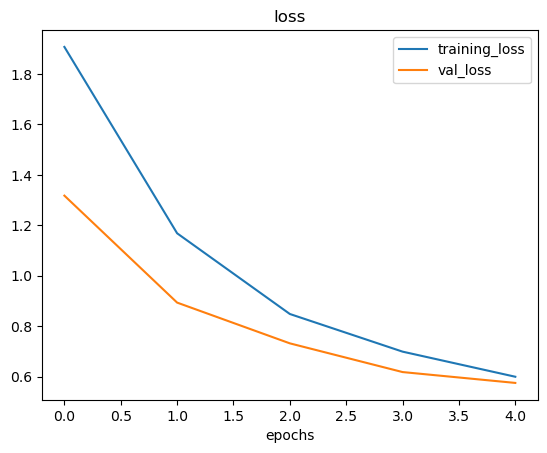

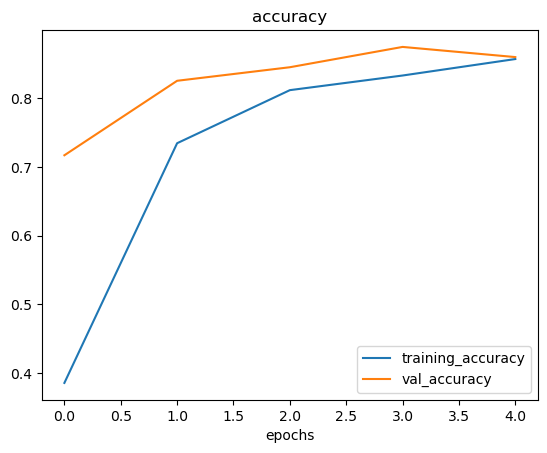

In [16]:
# Check out our model's training curves
plot_loss_curves(history=history_10_percent)

Video N°162: Getting a feature vector from our trained model

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePoolin2D.

In [21]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [23]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor=input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

> 🛠 **Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens.

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a **feature vector** (a long tensor of numbers which represents the leatned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then used to extract patterns out of for our own specific problem. 

Video N°163: Drilling into the concept of a feature vector (a learned representation)
Video N°164: Downloading and preparing the data for Model 1(1 percent of training data) 

## Running a series of transfer learning experiments

We've seen the incredible  results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... How about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑 **Note:** throughout all experiments the same tests dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [54]:
# Download and unzip data - preprocessed from Food101
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip"
download_data(url=url, file_path="10_food_classes_1_percent.zip", extract=True)

The file 10_food_classes_1_percent.zip already exists.
Extracting 10_food_classes_1_percent.zip as ZIP...
10_food_classes_1_percent.zip has been extracted to current directory.


In [55]:
# Create training and test dir
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [56]:
# How many images are we working with?
walk_through_dir(dir_path="10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There a

In [57]:
# Check previously saved arguments
idfd_args

{'image_size': (224, 224), 'label_mode': 'categorical', 'batch_size': 32}

In [58]:
# Setup data loaders
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           **idfd_args)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                **idfd_args)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Video N°165: Building a data augmentation layer to use inside our model

## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing of doing this within the TensorFlow Data augmentation documentation:
https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenation them) happens on the GPU (much faster) rather than the CPU.
* Image data augmenation only happens during training, so we can still export our whole model and use it elsewhere.

In [59]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmenation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255) # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
], name="data_augmentation")

N°166: Note: Small fix for next video, for images not augmenting
**Old:**
```python
augmented_img = data_augmentation(img)
```
**New:**
```python
augmented_img = data_augmentation(img, training=True)
```

Video N°167: Visualizing what happens when images pass through our data augmentation layer

### Visualize our data augmentation layer (and see what happens to our data)

In [125]:
# View a random image and compare it to its augmented version
from pathlib import Path
import random

base_dir = Path("10_food_classes_1_percent/train")
target_class = random.choice(train_data_1_percent.class_names)
target_dir = base_dir / target_class
random_image_path = random.choice(list(target_dir.glob('*')))

In [132]:
from MachineLearningUtils.data_visualization.augmentation_effects import apply_model_and_compare

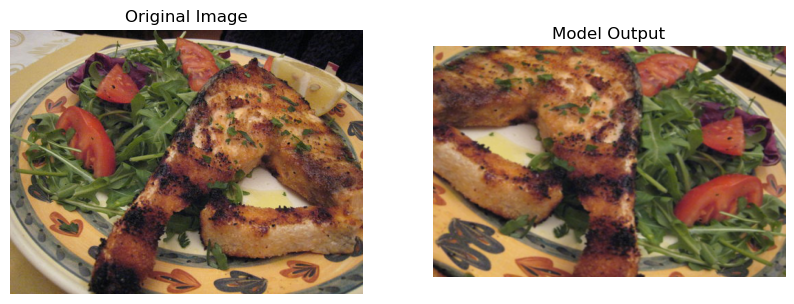

In [133]:
apply_model_and_compare(img_path=random_image_path,
                        model=data_augmentation)